In [3]:
import time

import torch
from constraint import AllDifferentConstraint, Problem
from torch_geometric.data import Data
from torch_geometric.utils import degree

from custom.utils import *

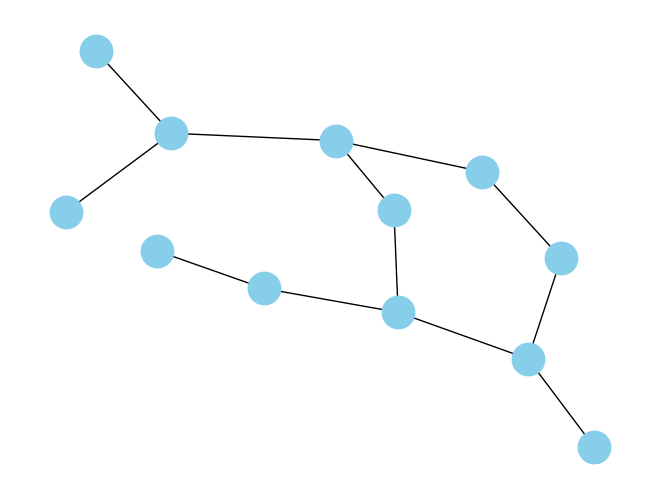

In [10]:
def mutual_pairs(attention_nodes, i=0):
    outer_layer = attention_nodes[i]
    g1_attention, g2_attention = outer_layer

    mutual_pairs = []

    for g1_node, g1_attends in enumerate(g1_attention):
        for g2_node in g1_attends:
            if g1_node in g2_attention[g2_node]:
                pair = (g1_node, g2_node)
                if pair not in mutual_pairs:
                    mutual_pairs.append(pair)

    random.shuffle(mutual_pairs)
    return mutual_pairs


import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from itertools import product


# Function to convert torch_geometric Data object to NetworkX graph


# Function to convert NetworkX graph to torch_geometric Data object


# Function to implement MCSplit algorithm


def max_common_subgraph(data1, data2):
    def pyg_to_nx(data):
        return to_networkx(data, to_undirected=True)

    def nx_to_pyg(G):
        return from_networkx(G)

    def mc_split(G1, G2):
        incumbent = []
        max_size = 0

        def search(mapping, future, incumbent):
            nonlocal max_size
            if len(mapping) > max_size:
                max_size = len(mapping)
                incumbent = mapping[:]
            bound = len(mapping) + sum(min(len(g), len(h)) for g, h in future)
            if bound <= max_size:
                return incumbent
            # Select label class
            G, H = min(future, key=lambda x: max(len(x[0]), len(x[1])))
            v = max(G, key=lambda x: G1.degree[x])
            for w in H:
                future_prime = []
                for G_prime, H_prime in future:
                    G_prime_adj = [
                        u for u in G_prime if u != v and u in G1.neighbors(v)
                    ]
                    H_prime_adj = [
                        u for u in H_prime if u != w and u in G2.neighbors(w)
                    ]
                    if G_prime_adj and H_prime_adj:
                        future_prime.append((G_prime_adj, H_prime_adj))
                    G_prime_non_adj = [
                        u for u in G_prime if u != v and u not in G1.neighbors(v)
                    ]
                    H_prime_non_adj = [
                        u for u in H_prime if u != w and u not in G2.neighbors(w)
                    ]
                    if G_prime_non_adj and H_prime_non_adj:
                        future_prime.append((G_prime_non_adj, H_prime_non_adj))
                incumbent = search(mapping + [(v, w)], future_prime, incumbent)
            G_prime = [u for u in G if u != v]
            future.remove((G, H))
            if G_prime:
                future.append((G_prime, H))
            incumbent = search(mapping, future, incumbent)
            return incumbent

        # Step 3: Start search with initial future and mapping
        future = [(list(G1.nodes), list(G2.nodes))]
        incumbent = search([], future, incumbent)

        return incumbent

    G1 = pyg_to_nx(data1)
    G2 = pyg_to_nx(data2)
    mapping = mc_split(G1, G2)
    common_nodes = [v for v, _ in mapping]
    subgraph = G1.subgraph(common_nodes)
    return nx_to_pyg(subgraph)


(graph1, graph2, attention_nodes) = torch.load("info.pt")

common_subgraph = max_common_subgraph(graph1, graph2)

plot_graph(common_subgraph)

# mp = mutual_pairs(attention_nodes, 0)
# print(mp)
# mcp = MCP(graph1, graph2)
# max_common_subgraph = mcp.solve()
# print("Maximum Common Subgraph:", max_common_subgraph)